In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
from keras.utils import plot_model
from keras import models
from keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_curve, auc, precision_score, accuracy_score, confusion_matrix

In [2]:
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) 

def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation = cv2.INTER_AREA)

In [25]:
disease_types=['covid', 'normal']
data_dir = '/Users/Mohammad/Desktop/data3/'
train_dir = os.path.join(data_dir)

In [26]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])      
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])

In [27]:
IMAGE_SIZE = 64
X = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values), total = len(train)):
    image = read_image(file)
    if image is not None:
        X[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
X /= 255.        
y = train['DiseaseID'].values
print(X.shape)
print(y.shape)

  0%|          | 0/7622 [00:00<?, ?it/s]

(7622, 64, 64, 3)
(7622,)


In [28]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state = 0)

In [29]:
np.random.seed(0)

model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Dropout(0.5))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))

model.add(layers.Dropout(0.5))
model.add(layers.Conv2D(528, (3, 3), activation='relu'))
model.add(layers.MaxPool2D((2, 2)))


model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [15]:
#model.summary()

In [30]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    batch_size=64, epochs=30,
                    verbose=1,validation_split=0.1)

Epoch 1/30
86/86 [==============================] - 151s 2s/step - loss: 0.9267 - accuracy: 0.6800 - val_loss: 0.3619 - val_accuracy: 0.7885
Epoch 2/30
86/86 [==============================] - 138s 2s/step - loss: 0.3624 - accuracy: 0.8061 - val_loss: 0.3358 - val_accuracy: 0.8492
Epoch 3/30
86/86 [==============================] - 129s 1s/step - loss: 0.3089 - accuracy: 0.8402 - val_loss: 0.2649 - val_accuracy: 0.8639
Epoch 4/30
86/86 [==============================] - 127s 1s/step - loss: 0.2976 - accuracy: 0.8618 - val_loss: 0.2102 - val_accuracy: 0.9033
Epoch 5/30
86/86 [==============================] - 126s 1s/step - loss: 0.3078 - accuracy: 0.8771 - val_loss: 0.1997 - val_accuracy: 0.9131
Epoch 6/30
86/86 [==============================] - 126s 1s/step - loss: 0.2301 - accuracy: 0.8963 - val_loss: 0.1995 - val_accuracy: 0.9049
Epoch 7/30
86/86 [==============================] - 147s 2s/step - loss: 0.2104 - accuracy: 0.8968 - val_loss: 0.2609 - val_accuracy: 0.8721
Epoch 8/30
86

In [31]:
y_pred = model.predict_classes(x_test)

/Applications/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [34]:
model.save('model.h5')

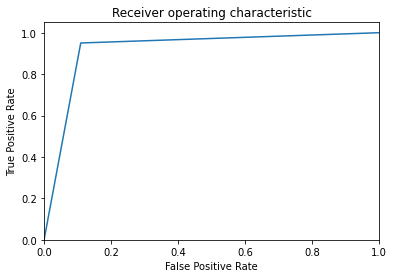

In [35]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred)
    roc_auc[i] = auc(fpr[i], tpr[i])

    
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

In [36]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

In [37]:
sp = tn/(tn+fp)
sn = tp/(tp+fn)

print('f1 score =  %.3f'%f1_score(y_test, y_pred))
print('Precision =  %.3f'%precision_score(y_test, y_pred))
print('Test accuracy =  %.3f'%accuracy_score(y_test, y_pred))
print('Specificity =  %.3f'%sp)
print('Sensitivity =  %.3f'%sn)

f1 score =  0.870
Precision =  0.801
Test accuracy =  0.910
Specificity =  0.890
Sensitivity =  0.950
